In [1]:
# importing required packages

In [2]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import math

In [3]:
# reading in data and getting btc only

In [4]:
df = pd.read_csv("binance_ohlcvf_data.csv")
dfbtc = df[df['asset']=='BTCUSDT'].copy()
dfbtc = dfbtc.reset_index(drop=True)

dfbtc["timestamp"] = pd.to_datetime(dfbtc["timestamp"], unit="ms")

cols_to_convert = ['open', 'high', 'low', 'close', 'volume', 'funding']
dfbtc[cols_to_convert] = dfbtc[cols_to_convert].astype(float)

print(dfbtc.iloc[:-1].isna().any()) # -1 because there won't be funding in yet for most recent day

asset        False
timestamp    False
open         False
high         False
low          False
close        False
volume       False
funding      False
dtype: bool


In [5]:
# getting returns and scaling to target volatility

In [6]:
dfbtc["return"] = dfbtc["close"].pct_change()
dfbtc["next_ret"] = dfbtc['return'].shift(-1)

dfbtc["rolling_vol"] = (
    dfbtc["return"]
      .rolling(window=30)
      .std()
)

ret_target_vol = 0.2/math.sqrt(365) # 20% annulised volatility

dfbtc['volscaled_next_ret'] = dfbtc['next_ret']*(ret_target_vol/dfbtc['rolling_vol'])

In [7]:
# creating feature

In [8]:
dfbtc["sma"] = dfbtc["close"].rolling(window=30).mean()
dfbtc['feature'] = dfbtc['close']/dfbtc['sma']

In [9]:
# plotting feature

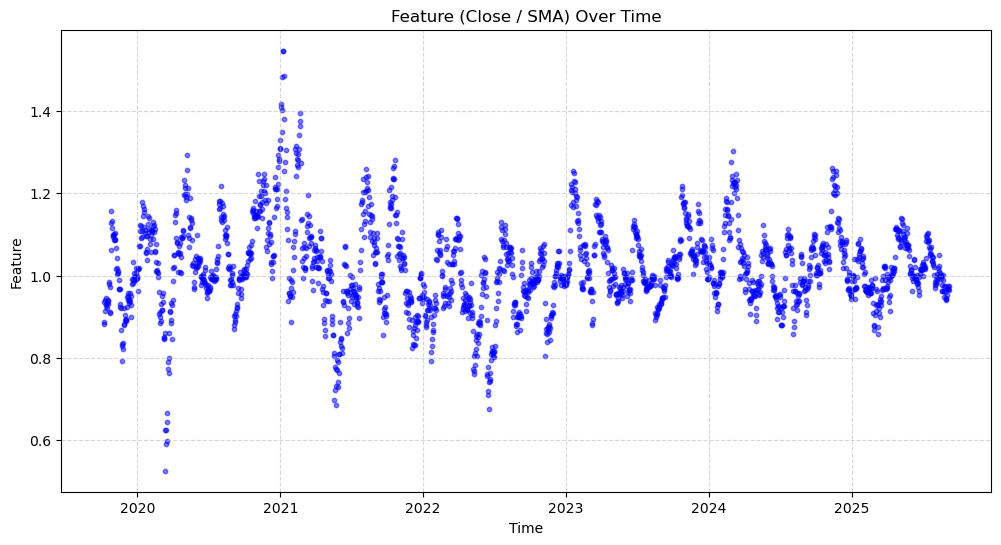

In [10]:
plt.figure(figsize=(12,6))
plt.scatter(dfbtc['timestamp'], dfbtc['feature'], s=10, alpha=0.5, color='blue')
plt.title("Feature (Close / SMA) Over Time")
plt.xlabel("Time")
plt.ylabel("Feature")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [11]:
# putting feature into deciles

In [12]:
dfbtc['feature_decile'] = pd.qcut(dfbtc['feature'], 10, labels=range(1,11))

print(dfbtc['feature_decile'].value_counts().sort_index())
decile_avg = dfbtc.groupby('feature_decile', observed=False)['feature'].mean()
print(decile_avg)

feature_decile
1     217
2     216
3     216
4     216
5     217
6     216
7     216
8     216
9     216
10    217
Name: count, dtype: int64
feature_decile
1     0.843423
2     0.927733
3     0.959057
4     0.980388
5     0.999313
6     1.022086
7     1.048807
8     1.077868
9     1.119436
10    1.219276
Name: feature, dtype: float64


In [13]:
## not volatility scaled returns

In [14]:
# scatter plot

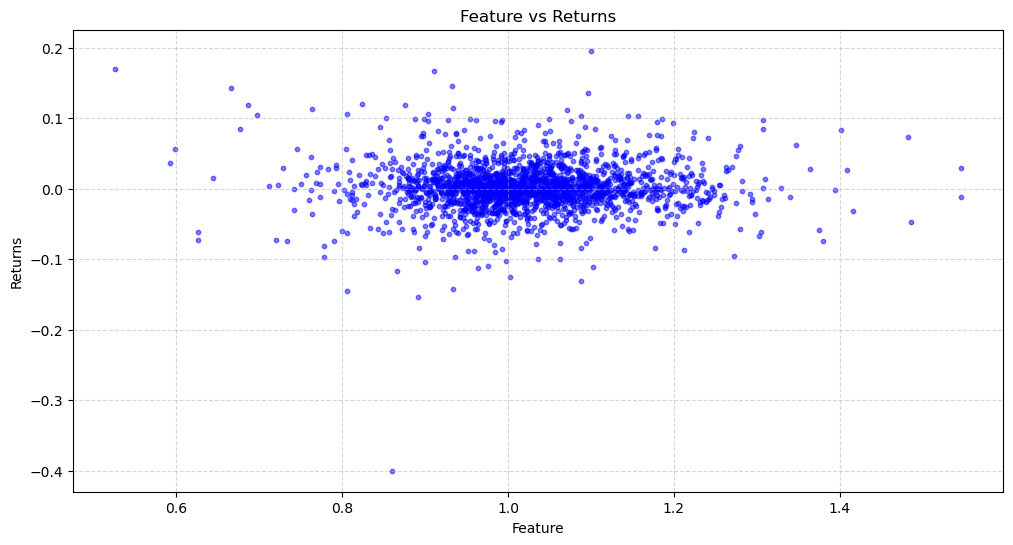

In [15]:
plt.figure(figsize=(12,6))
plt.scatter(dfbtc['feature'], dfbtc['next_ret'], s=10, alpha=0.5, color='blue')
plt.title("Feature vs Returns")
plt.xlabel("Feature")
plt.ylabel("Returns")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [16]:
# decile plot

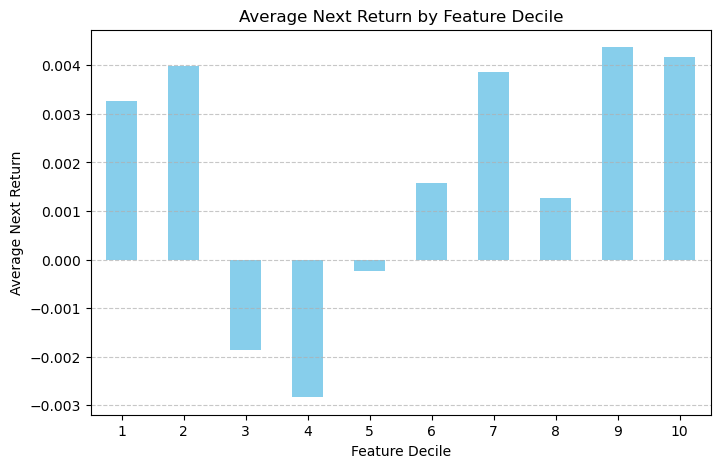

In [17]:
decile_avg_ret = dfbtc.groupby('feature_decile', observed=False)['next_ret'].mean()

plt.figure(figsize=(8,5))
decile_avg_ret.plot(kind='bar', color='skyblue')
plt.title("Average Next Return by Feature Decile")
plt.xlabel("Feature Decile")
plt.ylabel("Average Next Return")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [18]:
# cumulative returns

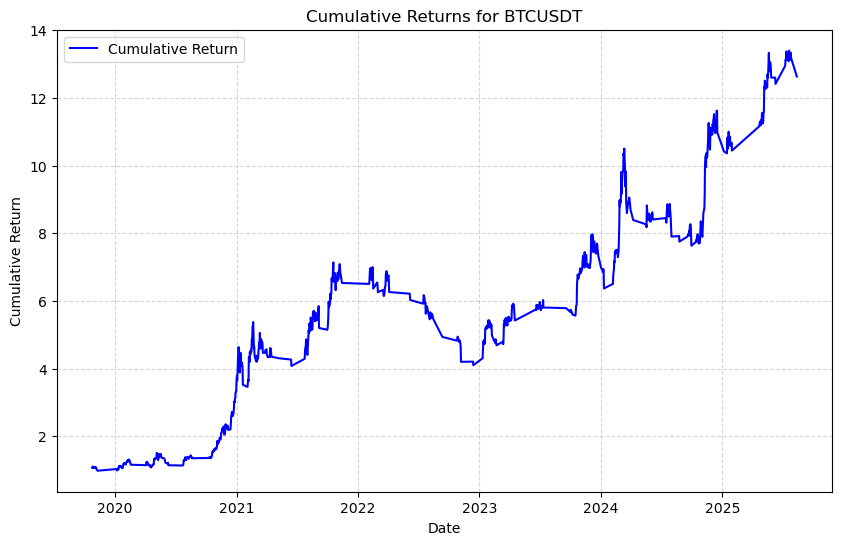

In [19]:
long_basket = dfbtc[dfbtc["feature_decile"].between(7, 10)].copy()

long_basket['cum_return'] = (1 + long_basket['next_ret']).cumprod()

plt.figure(figsize=(10,6))
plt.plot(long_basket['timestamp'], long_basket['cum_return'], color='blue', label='Cumulative Return')
plt.title("Cumulative Returns for BTCUSDT")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [20]:
## volatility scaled returns

In [21]:
# scatter plot

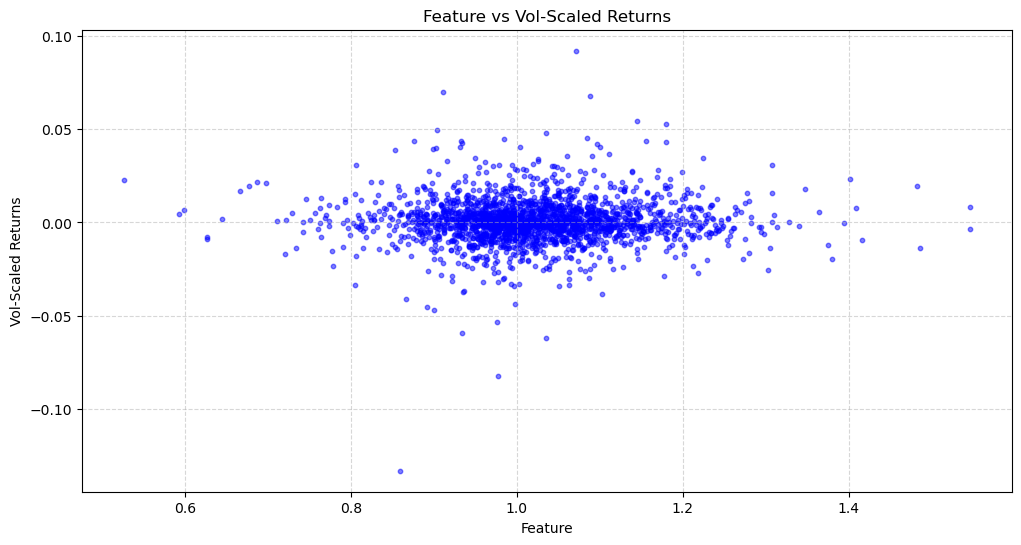

In [22]:
plt.figure(figsize=(12,6))
plt.scatter(dfbtc['feature'], dfbtc['volscaled_next_ret'], s=10, alpha=0.5, color='blue')
plt.title("Feature vs Vol-Scaled Returns")
plt.xlabel("Feature")
plt.ylabel("Vol-Scaled Returns")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

In [23]:
# decile plot

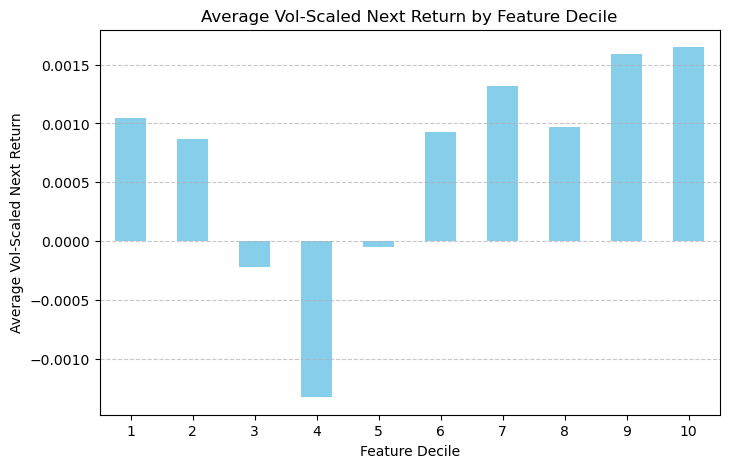

In [24]:
voladj_decile_avg_ret = dfbtc.groupby('feature_decile', observed=False)['volscaled_next_ret'].mean()

plt.figure(figsize=(8,5))
voladj_decile_avg_ret.plot(kind='bar', color='skyblue')
plt.title("Average Vol-Scaled Next Return by Feature Decile")
plt.xlabel("Feature Decile")
plt.ylabel("Average Vol-Scaled Next Return")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [25]:
# cumulative returns

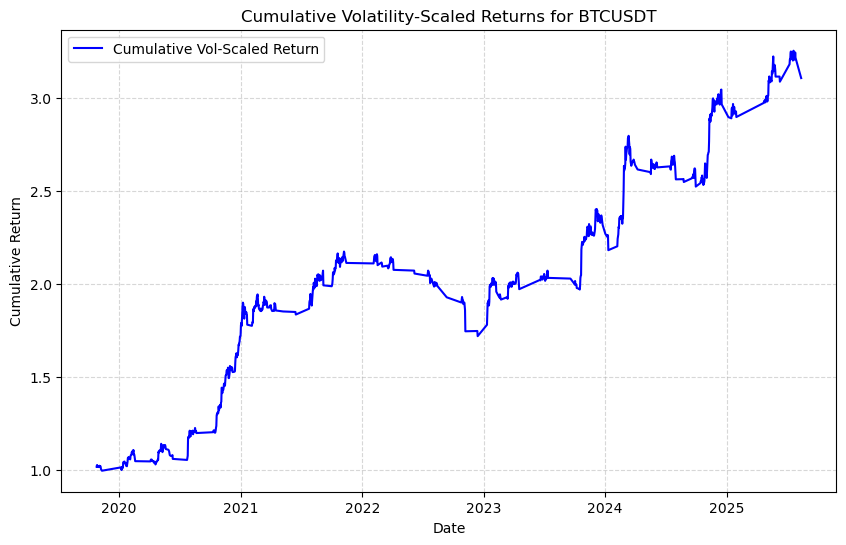

In [26]:
voladj_long_basket = dfbtc[dfbtc["feature_decile"].between(7, 10)].copy()

voladj_long_basket['cum_return'] = (1 + voladj_long_basket['volscaled_next_ret']).cumprod()

plt.figure(figsize=(10,6))
plt.plot(voladj_long_basket['timestamp'], voladj_long_basket['cum_return'], color='blue', label='Cumulative Vol-Scaled Return')
plt.title("Cumulative Volatility-Scaled Returns for BTCUSDT")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()

In [27]:
## cumulative returns when position sizing to feature decile

In [28]:
# trading deciles 7 to 10 so will take average increase in returns and increase positions relative to that
# note - this does mean trading at increased volatility

feature_decile
1     0.001047
2     0.000865
3    -0.000219
4    -0.001325
5    -0.000045
6     0.000928
7     0.001319
8     0.000967
9     0.001586
10    0.001647
Name: volscaled_next_ret, dtype: float64


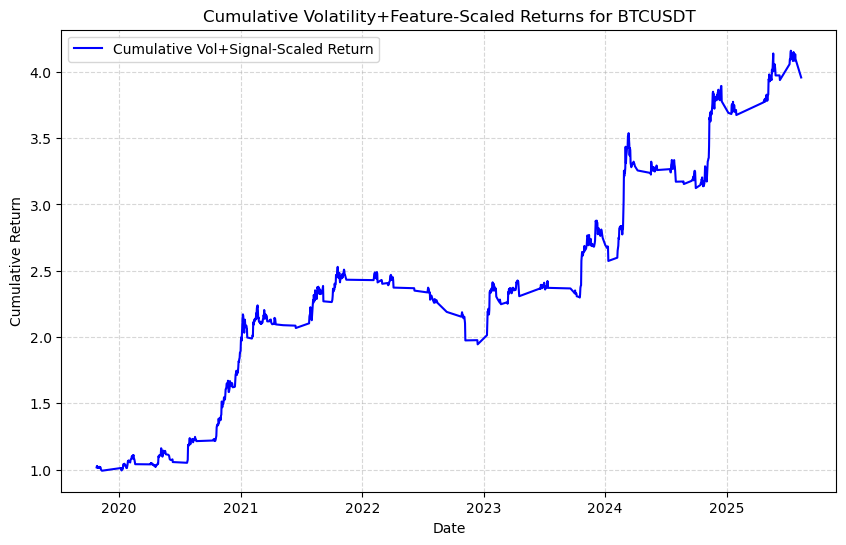

In [29]:
decile_ret_avg = dfbtc.groupby('feature_decile', observed=False)['volscaled_next_ret'].mean()
print(decile_ret_avg)

firstdiff = (decile_ret_avg[8] - decile_ret_avg[7])/decile_ret_avg[7]
seconddiff = (decile_ret_avg[9] - decile_ret_avg[8])/decile_ret_avg[8]
thirddiff = (decile_ret_avg[10] - decile_ret_avg[9])/decile_ret_avg[9]

avg_diff = (firstdiff+seconddiff+thirddiff)/3

dfbtc['featvolscaled_next_ret'] = None

for index in dfbtc.index:
    
    if dfbtc['feature_decile'].iloc[index] == 7:
        dfbtc.loc[index, 'featvolscaled_next_ret'] = dfbtc['volscaled_next_ret'].iloc[index]
    
    elif dfbtc['feature_decile'].iloc[index] == 8:
        dfbtc.loc[index, 'featvolscaled_next_ret'] = (1+avg_diff)*dfbtc['volscaled_next_ret'].iloc[index]

    elif dfbtc['feature_decile'].iloc[index] == 9:
        dfbtc.loc[index, 'featvolscaled_next_ret'] = (1+avg_diff*2)*dfbtc['volscaled_next_ret'].iloc[index]
        
    elif dfbtc['feature_decile'].iloc[index] == 10:
        dfbtc.loc[index, 'featvolscaled_next_ret'] = (1+avg_diff*3)*dfbtc['volscaled_next_ret'].iloc[index]

retadj_long_basket = dfbtc[dfbtc["feature_decile"].between(7, 10)].copy()

retadj_long_basket['cum_return'] = (1 + retadj_long_basket['featvolscaled_next_ret']).cumprod()

plt.figure(figsize=(10,6))
plt.plot(retadj_long_basket['timestamp'], retadj_long_basket['cum_return'], color='blue', label='Cumulative Vol+Signal-Scaled Return')
plt.title("Cumulative Volatility+Feature-Scaled Returns for BTCUSDT")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.show()